**DrivenData Usernames : **
Natasha Savic , 
Vaishali Raja (VaishaliR)

**Best Score:** 0.8150
**Ranking :** 534

## About

The task of this project, from Driven Data.org, is to predict which water pumps throughout Tanzania are functional, which of those requires repairs, and which are not functional at all. The prediction is based on a number of variables about what kind of pump is operating, when it was installed, and how is it managed. There were over 40 columns of variables with around 59000 samples. These features would be analyzed and certain features would be chosen and trained using different classifiers such as Random Forest and Decision Trees.

## Data loading and Exploration

In [1]:
import numpy as np
from numpy import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from sklearn.preprocessing import StandardScaler

**Pre-processing in Dataiku**

Before loading the data in, we conducted some pre-processing on the train and test datasets with the same recipe using Dataiku. The cleaning that was conducted was as follows: 

    1) Replaced True/False with 1/0
    2) Cleaned input values in installer, scheme_name, funder, ward
    3) Filled empty cells of installer with 'Other'
    
The cleaned datasets were then re-loaded in. For the train set, the status_group was dummiefied during the dataiku pre-processing which is why the last 3 columns need to be removed from the set.

In [2]:
train_l = pd.read_csv("./train_labels.csv")
train_p = pd.read_csv("water_prepared.csv")
test = pd.read_csv("test_prepared.csv")

In [3]:
train = train_p.iloc[:, :-3] #remove the last 3 variables
train_1 = pd.merge(train,train_l, on = 'id')

In [4]:
print('Train Data: \n')
print("Number of columns: "+ str(train_1.shape[1]))
print("Number of rows: "+ str(train_1.shape[0]))
print('\nTest Data: \n')
print("Number of columns: "+ str(test.shape[1]))
print("Number of rows: "+ str(test.shape[0]))

Train Data: 

Number of columns: 42
Number of rows: 59400

Test Data: 

Number of columns: 40
Number of rows: 14850


In [5]:
#Now drop the  'Index' colum created during the dataiku cleaning process since it's unnecessary for  the prediction process.
train_1.drop("Index", axis = 1, inplace = True)

In [6]:
#Keep a copy of the id values and  drop the  'Id' colum since it's unnecessary for  the cleaning and training process.
train_1_ID = train['id']
test_ID = test['id']

train_1.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

**Description of rows / columns in train and test set and status_group**

In [7]:
print('Train Data: \n')
print("Number of columns: "+ str(train_1.shape[1]))
print("Number of rows: "+ str(train_1.shape[0]))
print('\nTest Data: \n')
print("Number of columns: "+ str(test.shape[1]))
print("Number of rows: "+ str(test.shape[0]))

Train Data: 

Number of columns: 40
Number of rows: 59400

Test Data: 

Number of columns: 39
Number of rows: 14850


In [8]:
train_1.status_group.describe()

count          59400
unique             3
top       functional
freq           32259
Name: status_group, dtype: object

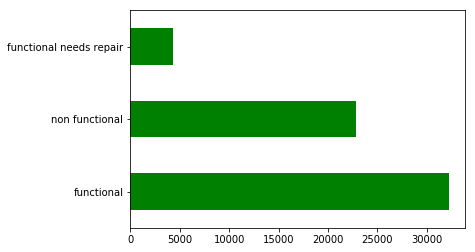

In [9]:
train_1.status_group.value_counts().plot(kind='barh', color='green')
plt.show()

**Data Cleaning and Transformations:**

   To easily clean the dataset, we are going to be merging the training and testing datasets. But before we do that, we will extract the target variable of status_group and evaluate if any transformations need to be performed. Once that has been completed, the merged dataset (sans status_group) will be split into categorical and numerical sets for data imputation and cleaning. 
   After a few rounds of base model running, new features were created or removed based on the scores obtained. The following are attempts that were not kept in the final model: 
   
1. Creating categorical values from construction year (Changed it to 60's, 70's etc based on year range). - Reduced the final score considerably and was thus removed. 
2. Attempted to remove scheme_management 

In [10]:
#Drop target variable from train dataset
target = train_1['status_group']
train = train_1.drop(['status_group'], axis=1)

In [11]:
#Merge train and test sets
print('Train Data before merge: \n')
print("Number of columns: "+ str(train.shape[1]))
print("Number of rows: "+ str(train.shape[0]))
print('\nTest Data before merge: \n')
print("Number of columns: "+ str(test.shape[1]))
print("Number of rows: "+ str(test.shape[0]))

m_data = pd.concat([train, test], ignore_index=True)

print('\nMerged Data: \n')
print("Number of columns: "+ str(m_data.shape[1]))
print("Number of rows: "+ str(m_data.shape[0]))

Train Data before merge: 

Number of columns: 39
Number of rows: 59400

Test Data before merge: 

Number of columns: 39
Number of rows: 14850

Merged Data: 

Number of columns: 39
Number of rows: 74250


## Further Cleaning of Dataset

**Categorical Values**

In [12]:
#Split into Categorical and Numerical Values
cat_columns = [col for col in m_data.columns.values if m_data[col].dtype == 'object']

# dataframe with categorical features
data_cat = m_data[cat_columns]

print('Checks: \n')
print("Number of columns: "+ str(data_cat.shape[1]))
print("Number of rows: "+ str(data_cat.shape[0]))
print("Column Names: "+ str(data_cat.columns))

#Percentage of missing values in Categorical Variable
data_cat_na = (data_cat.isnull().sum() / len(data_cat)) * 100
data_cat_na = data_cat_na.drop(data_cat_na[data_cat_na == 0].index).sort_values(ascending=False)[:30]
missing_data_c = pd.DataFrame({'Missing Ratio for Categorical Var' :data_cat_na})
print('\n Missing Ratio for Cat variable: \n')
print("Table: " + str(missing_data_c))

Checks: 

Number of columns: 28
Number of rows: 74250
Column Names: Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'recorded_by',
       'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

 Missing Ratio for Cat variable: 

Table:             Missing Ratio for Categorical Var
funder                               6.065993
subvillage                           0.632997


We will take a look at the number of distinct values that each feature has and assess the importance of keeping each feature. In the instance that a feature with high number of distinct values are kept,the we will try to reduce the number of distinct values by aggregating the lower halves.

In [13]:
from collections import Counter

for col in ('date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'recorded_by',
       'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'):
    unique_words = set(data_cat[col])             # == set(['a', 'b', 'c'])
    unique_word_count = len(unique_words) # == 3
    print(col,unique_word_count)
    

date_recorded 369
funder 2133
installer 2167
wpt_name 45684
basin 9
subvillage 21426
region 21
lga 125
ward 2017
recorded_by 1
scheme_management 13
scheme_name 2847
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 2
quality_group 3
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6


Before proceeding with cleaning and feature engineering, we are dropping the following columns: 
    
    Reason: High number of distinct values that do not add value to the information set
    
        - subvillage
        - wpt_name
        
    Reason: Contains duplicate information that can be explained by other columns
        - extraction_type
        - extraction_type_class
        - waterpoint_type_group
        - management_group
        - payment
        - scheme_name
        - source_type
        - region
        - recorded_by
        - quality_group
        - quantity_group

In [14]:
#drop some columns we don't need or are duplicated
cols = ('wpt_name','subvillage','region','recorded_by','scheme_name','extraction_type_class', 
            'extraction_type','management_group','payment','quality_group','quantity_group',
            'source_type','waterpoint_type_group')

for c in cols :
    data_cat.drop(c,inplace = True, axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [18]:
data_cat.shape

(74250, 15)

- Imputing missing values in funder with 'OTHER'
- Bringing down the number of variables in funder, installer and schement_management by only taking those values with count >1000 and aggregating the others into 'OTHER'

In [19]:
data_cat['funder'] = data_cat['funder'].fillna('OTHER')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
#Regrouping funder and installer based on top few categories to reduce the number of variables.
data_cat.installer.value_counts()

DWE                         21779
OTHER                        9039
GOV                          6289
COM                          2343
RWE                          1707
DAN                          1305
KKT                          1132
Hesawa                       1088
WORLDVISION                   880
ADRA                          873
TCRS                          843
DANID                         786
CES                           765
HESAWS                        680
WVT                           664
FinWater                      540
Amref                         538
TASAF                         523
FW                            522
LGA                           501
Wedeco                        500
NORAD                         475
OXFARM                        409
TWESA                         395
WORLDBANK                     384
Jaica                         358
Dmdd                          356
Fini Water                    345
Di                            329
DHV           

In [21]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the information contained in the column.

def installer_wrangler(row):  
    '''Keep values with more than 1000 values and set the rest to 'other'''

    if row['installer']=='DWE':
        return 'DWE'
    elif row['installer']=='GOV':
        return 'GOV'
    elif row['installer']=='COM':
        return 'COM'
    elif row['installer']=='RWE':
        return 'RWE'
    elif row['installer']=='DAN':
        return 'DAN'    
    elif row['installer']=='KKT':
        return 'KKT' 
    elif row['installer']=='Hesawa':
        return 'Hesawa' 
    else:
        return 'OTHER'

In [22]:
data_cat['installer'] = data_cat.apply(lambda row: installer_wrangler(row), axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
data_cat.funder.value_counts()

Government Of Tanzania      11299
OTHER                        4504
Danida                       3907
Hesawa                       2782
Rwssp                        1703
World Bank                   1701
Kkkt                         1623
World Vision                 1562
Unicef                       1324
Tasaf                        1136
Dhv                          1065
District Council             1037
Private Individual           1034
Dwsp                         1012
0                             980
Norad                         949
Germany Republi               765
Water                         739
Tcrs                          735
Ministry Of Water             728
Dwe                           605
Netherlands                   592
Hifab                         577
Adb                           551
Lga                           546
Ces                           526
Amref                         525
Fini Water                    474
Oxfam                         436
Wateraid      

In [24]:
def funder_wrangler(row):  
    '''Keep values with more than 1000 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'GOV'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank'   
    elif row['funder']=='Kkkt':
        return 'kkkt'
    elif row['funder']=='World Vision':
        return 'world_vision'
    elif row['funder']=='Unicef':
        return 'unicef'
    elif row['funder']=='Tasaf':
        return 'tasaf'
    elif row['funder']=='Dhv':
        return 'dhv'
    elif row['funder']=='District Council':
        return 'district_council'
    else:
        return 'OTHER'
    
data_cat['funder'] = data_cat.apply(lambda row: funder_wrangler(row), axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
data_cat.scheme_management.value_counts()

VWC                 45917
WUG                  6496
unknown              4846
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [26]:
def scheme_management(row):  
    '''Keep values with more than 1000 values and set the rest to 'other'''

    if row['scheme_management']=='Other':
        return 'OTHER'
    elif row['scheme_management']=='SWC':
        return 'OTHER'
    elif row['scheme_management']=='Trust':
        return 'OTHER'
    elif row['scheme_management']=='None':
        return 'OTHER'
    else:
        return row['scheme_management']
    
data_cat['scheme_management'] = data_cat.apply(lambda row: scheme_management(row), axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [27]:
#Performing check on the distinct values
from collections import Counter

for col in ('date_recorded', 'funder', 'installer', 'basin', 'lga', 'ward',
       'scheme_management', 'extraction_type_group', 'management',
       'payment_type', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type'):
    unique_words = set(data_cat[col])             # == set(['a', 'b', 'c'])
    unique_word_count = len(unique_words) # == 3
    print(col,unique_word_count)

date_recorded 369
funder 12
installer 8
basin 9
lga 125
ward 2017
scheme_management 10
extraction_type_group 13
management 12
payment_type 7
water_quality 2
quantity 5
source 10
source_class 3
waterpoint_type 7


After the initial run, a new feature was created 'days_since' which provides information on the from the date recorded to the latest date recorded. 

In [28]:
#Change date_Recorded to datetime
from datetime import datetime, timedelta

datedf = data_cat['date_recorded']
data_cat['date_recorded'] = pd.to_datetime(data_cat['date_recorded'], yearfirst = True, format = '%Y-%m-%d')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [29]:
data_cat.date_recorded.describe()

count                   74250
unique                    369
top       2011-03-17 00:00:00
freq                      695
first     2001-03-26 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [30]:
# The most recent data is 2013-12-03. Subtract each date from this point to obtain a 'days_since_recorded' column.

date_format = "%Y-%m-%d"
latest = datetime(2013,12,3)
latest

datetime.datetime(2013, 12, 3, 0, 0)

In [31]:
data_cat['days_since'] =  latest - data_cat['date_recorded']
data_cat.days_since = data_cat.days_since.astype(int)
data_cat.date_recorded = data_cat.date_recorded.astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [32]:
#Check chunk to see the shape, missing variables and unique value count
from collections import Counter
print('Checks: \n')
print("Number of columns: "+ str(data_cat.shape[1]))
print("Number of rows: "+ str(data_cat.shape[0]))
print("Column Names: "+ str(data_cat.columns))

#Percentage of missing values in Categorical Variable
data_cat_na = (data_cat.isnull().sum() / len(data_cat)) * 100
data_cat_na = data_cat_na.drop(data_cat_na[data_cat_na == 0].index).sort_values(ascending=False)[:30]
missing_data_c = pd.DataFrame({'Missing Ratio for Categorical Var' :data_cat_na})
print('\n Missing Ratio for Cat variable: \n')
print("Table: " + str(missing_data_c))

for col in ('date_recorded', 'funder', 'installer', 'basin', 'lga', 'ward',
       'scheme_management', 'extraction_type_group', 
       'payment_type', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type', 'days_since'):
    unique_words = set(data_cat[col])             # == set(['a', 'b', 'c'])
    unique_word_count = len(unique_words) # == 3
    print(col,unique_word_count)

Checks: 

Number of columns: 16
Number of rows: 74250
Column Names: Index(['date_recorded', 'funder', 'installer', 'basin', 'lga', 'ward',
       'scheme_management', 'extraction_type_group', 'management',
       'payment_type', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type', 'days_since'],
      dtype='object')

 Missing Ratio for Cat variable: 

Table: Empty DataFrame
Columns: [Missing Ratio for Categorical Var]
Index: []
date_recorded 369
funder 12
installer 8
basin 9
lga 125
ward 2017
scheme_management 10
extraction_type_group 13
payment_type 7
water_quality 2
quantity 5
source 10
source_class 3
waterpoint_type 7
days_since 369


**Use labelencoder to create ordinal values from some categorical values**

Onehotencoding was attempted but the results of the onehot encoder was not better. This could possibly have been due to the huge number of variables that are created.

In [33]:
#labelencoding 
from sklearn.preprocessing import LabelEncoder

for col in ('funder', 'installer', 'scheme_management', 'basin','extraction_type_group', 'payment_type', 'management',
            'water_quality', 'quantity', 'source','source_class', 'waterpoint_type'):
    lbl = LabelEncoder() 
    lbl.fit(list(data_cat[col].values)) 
    data_cat[col] = lbl.transform(list(data_cat[col].values))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
#get dummies
data_cat = pd.get_dummies(data_cat)

In [35]:
print('Checks: \n')
print("Number of columns: "+ str(data_cat.shape[1]))
print("Number of rows: "+ str(data_cat.shape[0]))
print("Column Names: "+ str(data_cat.columns))


Checks: 

Number of columns: 2156
Number of rows: 74250
Column Names: Index(['date_recorded', 'funder', 'installer', 'basin', 'scheme_management',
       'extraction_type_group', 'management', 'payment_type', 'water_quality',
       'quantity',
       ...
       'ward_Yakobi', 'ward_Zagayu', 'ward_Zanka', 'ward_Ziba',
       'ward_Zinga/Ikerege', 'ward_Zirai', 'ward_Ziwani', 'ward_Zoissa',
       'ward_Zongomera', 'ward_Zuzu'],
      dtype='object', length=2156)


In [36]:
print ("Checkinf for NaN and Inf")
print ("np.nan=", np.where(np.isnan(data_cat)))
print ("is.inf=", np.where(np.isinf(data_cat)))

Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))


**Numerical Values**

In [37]:
# dataframe with numerical features
data_num = m_data.drop(cat_columns, axis=1)

print('Checks: \n')
print("Number of columns: "+ str(data_num.shape[1]))
print("Number of rows: "+ str(data_num.shape[0]))
print("Column Names: "+ str(data_num.columns))

#Percentage of missing values in Numerical Variables
data_num_na = (data_num.isnull().sum() / len(data_num)) * 100
data_num_na = data_num_na.drop(data_num_na[data_num_na == 0].index).sort_values(ascending=False)[:30]
missing_data_n = pd.DataFrame({'Missing % of NA in Numerical Var' :data_num_na})
print('\n Missing % of NA in Num variable: \n')
print("Table: " + str(missing_data_n))

Checks: 

Number of columns: 11
Number of rows: 74250
Column Names: Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'public_meeting',
       'permit', 'construction_year'],
      dtype='object')

 Missing % of NA in Num variable: 

Table:                 Missing % of NA in Numerical Var
public_meeting                          5.595960
permit                                  5.108418


Before proceeding with cleaning and feature engineering, we are dropping the following columns:
 
  - num_private
  - public_meeting
  - amount_tsh
  - gps_height
  
After dropping the abovemention columns, the variables with missing values are imputed with a 0.


In [38]:
#drop some columns we don't need or are duplicated
cols = ('num_private','public_meeting','amount_tsh','gps_height')

for c in cols :
    data_num.drop(c,inplace = True, axis = 1)

In [39]:
data_num['permit'] = data_num['permit'].fillna(0)

We'll check on the number of 0's in the different variables. 

In [40]:
#Which columns are suspects to have false 0's that are actually na's?
print((data_num == 0).sum())

longitude             2269
latitude                 0
region_code              0
district_code           27
population           26834
permit               52399
construction_year    25969
dtype: int64


For some variables like 'permit' and 'district', it is acceptable to have a high number of 0 as they are either boolean or part of the value set. However, it affects the modelling process when variables like 'construction_year' and 'population' have 0 as these are obviously incorrect values. As such they would be imputed using the following methods : 

    1)Longtitude, Latitude - Using the mean of the region where they are located. 
    2)Population - Using the mean of the district where they are located
    3)Construction_year - Using the median of the district where they are located.

In [41]:
#All missing values of latitude, longitude and height (listed as 0s) are converted to the mean value within their administrative region
a= data_num[data_num["longitude"] < 1]
a.iloc[:,data_num.columns == "latitude"]= np.nan
a.iloc[:,data_num.columns == "longitude"]= np.nan
data_num[data_num["longitude"] < 1] = a
data_num["longitude"] = data_num.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude.astype(np.float32)
data_num["latitude"] = data_num.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude.astype(np.float32)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
#data_num.population=pd.to_numeric(data_num.population)

a= data_num[data_num["population"] < 2]
a.iloc[:,data_num.columns == "population"]= np.nan
data_num[data_num["population"] < 2] = a
data_num["population"] = data_num.groupby("district_code").transform(lambda x: x.fillna(x.mean())).population.astype(np.float32)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [43]:
a= data_num[data_num["construction_year"] < 1]
a.iloc[:,data_num.columns == "construction_year"]= np.nan
data_num[data_num["construction_year"] < 1] = a
data_num["construction_year"] = data_num.groupby("district_code").transform(lambda x: x.fillna(x.median())).construction_year.astype(np.float32)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
#Percentage of missing values in Numerical Variables
data_num_na = (data_num.isnull().sum() / len(data_num)) * 100
data_num_na = data_num_na.drop(data_num_na[data_num_na == 0].index).sort_values(ascending=False)[:30]
missing_data_n = pd.DataFrame({'Missing Ratio for Numerical Var' :data_num_na})
print('\n Missing Ratio for Num variable: \n')
print("Table: " + str(missing_data_n))


 Missing Ratio for Num variable: 

Table:                    Missing Ratio for Numerical Var
construction_year                         0.167003
population                                0.053872


We note that even after the imputation, there are some values which are missing. These values are imputed with the mean of the variable.

In [45]:
data_num["population"] = data_num["population"].fillna(data_num["population"].mean())
data_num["construction_year"] = data_num["construction_year"].fillna(data_num["population"].mean())

In [46]:
print((data_num == 0).sum())

longitude                0
latitude                 0
region_code              0
district_code           27
population               0
permit               52399
construction_year        0
dtype: int64


In [47]:
#Percentage of missing values in Numerical Variables
data_num_na = (data_num.isnull().sum() / len(data_num)) * 100
data_num_na = data_num_na.drop(data_num_na[data_num_na == 0].index).sort_values(ascending=False)[:30]
missing_data_n = pd.DataFrame({'Missing Ratio for Numerical Var' :data_num_na})
print('\n Missing Ratio for Num variable: \n')
print("Table: " + str(missing_data_n))


 Missing Ratio for Num variable: 

Table: Empty DataFrame
Columns: [Missing Ratio for Numerical Var]
Index: []


**Reduce skewness in numerical values**

In [49]:
from scipy.stats import skew,norm
from scipy.special import boxcox1p

skew_features = data_num.apply(lambda x: skew(x.dropna())).sort_values(ascending=False) 
skewness = pd.DataFrame({'Skew' :skew_features})
skewness

,Skew
population,13.249703
district_code,3.961353
region_code,3.179390
permit,0.902788
longitude,-0.077025
latitude,-0.304708
construction_year,-23.600397


In [50]:
#Apply box-cox transformation for numerical variables with skewness more than 0.75
#skewness = skewness[abs(skewness) > 0.75]

#skewed_features = skewness.index
lam = 0.15
for c in ('district_code','region_code','permit'):
    data_num[c] = boxcox1p(data_num[c], lam)

In [51]:
for col in ('region_code', 'district_code', 'permit'):
    data_num[col] = data_num[col].astype(int)

In [52]:
data_num.dtypes

longitude            float32
latitude             float32
region_code            int64
district_code          int64
population           float32
permit                 int64
construction_year    float32
dtype: object

In [53]:
print ("Checkinf for NaN and Inf")
print ("np.nan=", np.where(np.isnan(data_num)))
print ("is.inf=", np.where(np.isinf(data_num)))
print ("np.max=", np.max(abs(data_num)))

Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
np.max= longitude               40.345192
latitude                11.649440
region_code              6.000000
district_code            6.000000
population           30500.000000
permit                   0.000000
construction_year     2013.000000
dtype: float64


## Modelling

In [54]:
#Merging datasets and printing out the dimensions of the merged dataset.
data = pd.concat([data_num, data_cat], axis=1)
print(data.shape)

(74250, 2163)


In [55]:
#Creating train and test sets

n_train = train_1.shape[0]
n_test = test.shape[0]
y_target = target
train = pd.DataFrame(data[:n_train])
test = pd.DataFrame(data[n_train:])

print(train.shape)
print(test.shape)
print(y_target.shape)

(59400, 2163)
(14850, 2163)
(59400,)


**Creating train-test split**

In [56]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(train, y_target, test_size = 0.30, random_state = 1)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(Y_train.shape))
print("y_test : " + str(Y_test.shape))

X_train : (41580, 2163)
X_test : (17820, 2163)
y_train : (41580,)
y_test : (17820,)


## Modelling

In [57]:
from sklearn.ensemble import RandomForestClassifier
modelRFC = RandomForestClassifier(n_estimators=1000,min_samples_split=10,criterion='gini')
modelRFC.fit(X_train, Y_train)

scoreRFC= modelRFC.score(X_test,Y_test)
print ('Random Forest' ,scoreRFC)

Random Forest 0.8103254769921436


In [ ]:
#This was a randomn forest grid search algorithm which took more than 5 hours and was still running 
#and hence had to be shut down

#from sklearn.grid_search import GridSearchCV

#RFC = RandomForestClassifier(n_estimators=1000)

#param_grid = {"n_estimators" : [800,1200],
              #"max_depth": [5, None],
              #"min_samples_split": [2, 5, 10,15],
              #"min_samples_leaf": [1, 5, 10],
              #"bootstrap": [True, False],
              #"criterion": ["gini", "entropy"]}

#grid_search = GridSearchCV(RFC, param_grid=param_grid)

#grid_search.fit(X_train, Y_train)

#scoreRFC= grid_search.score(X_test,Y_test)
#print ('Random Forest' ,scoreRFC)

In [58]:
from sklearn.tree import DecisionTreeClassifier
modelDTC = DecisionTreeClassifier(min_samples_split=20, random_state=99)
modelDTC.fit(X_train, Y_train)

scoreDTC= modelDTC.score(X_test,Y_test)
print ('Decision Tree', scoreDTC)

Decision Tree 0.7738496071829405


## Extremely randomised trees
In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

In [59]:
modelETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)
modelETC.fit(X_train, Y_train)

scoreETC= modelETC.score(X_test,Y_test)
print ('Extra Trees Classifiers', scoreETC)

Extra Trees Classifiers 0.8065656565656566


Text(0,0.5,'Score')

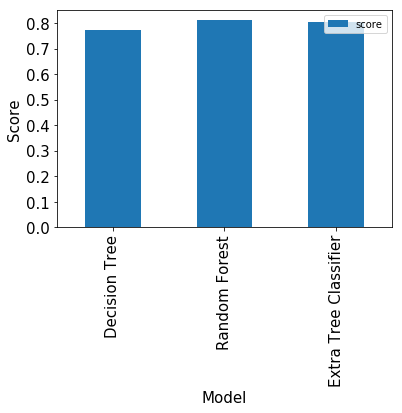

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline 
pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="Bar", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)

## Final Model and Classification Report

Based on the above obtained validation results we see that Random Forest yields the best classification result compared to other methods. Hence, we decide to create a classification report and confusion matrix of this particular algorithm. We can conclude that our model acts as a good classifier for labeling functional and non-functional pumps. Improvements could be made for the pumps that are functional and need repair. However, this class represents only 14% of the events. Consequently, we are satisfied that our classifer correctly labels the majority classes with a F1 score of 85% for functional- and 81% for non-functional pumps. 

------------------
                         precision    recall  f1-score   support

             Functional       0.80      0.91      0.85      9691
Functional Needs Repair       0.62      0.27      0.38      1270
         Non Functional       0.85      0.77      0.81      6859

            avg / total       0.80      0.81      0.80     17820

------------------


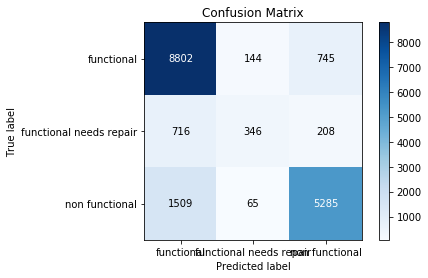

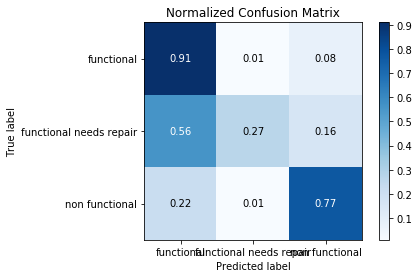

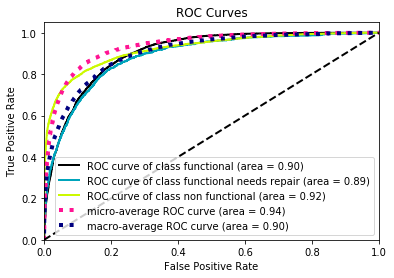

In [61]:
import scikitplot as skplt
from sklearn.metrics import classification_report

#Model definiton
modelRFC = RandomForestClassifier(n_estimators=1000,min_samples_split=10,criterion='gini')
modelRFC.fit(X_train, Y_train)

#Make predictions for train and test data
rfrpred = modelRFC.predict(X_test)
rfrprob = modelRFC.predict_proba(X_test) #prob for the ROC


def diagnosticplot(probprediction, predictions):
    skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=False) #CREATE A CONFUSION MATRIX
    skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=True) #normalized matrix 
    print('------------------')
    print(classification_report(Y_test, predictions, target_names=['Functional', 'Functional Needs Repair', 'Non Functional']))
    print('------------------')
    skplt.metrics.plot_roc_curve(Y_test, probprediction) #roc curve based on predicted probabilities
    plt.show()
    return;
diagnosticplot(rfrprob, rfrpred)

In [63]:
print(modelRFC.feature_importances_) #-> see printout below for the result

[7.00797232e-02 6.86890573e-02 9.87036072e-03 ... 2.68953601e-05
 9.87088155e-05 5.09520578e-05]


# Final run on test values
 

In [ ]:
modelRFC = RandomForestClassifier(n_estimators=1000,min_samples_split=10,criterion='gini')

modelRFC.fit(train.values, y_target)
RFC_pred = modelRFC.predict(test.values)


In [ ]:
final = pd.DataFrame()
final['id'] = test_ID
final['status_group'] = RFC_pred
final.to_csv('submission.csv',index=False)